In [128]:
#Imports and API Key
#V1.4 implementing XGBoost

import pandas as pd
import quandl
from scipy import stats
import scipy
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import roc_auc_score

from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence

import xgboost as xgb

%aimport dataclean

quandl.ApiConfig.api_key = 'm8FYMyoCaJSbTrBASNHh'

In [129]:
#pulling data from Quandl

data = pd.read_csv('data_for_pull.csv') #staging the QUANDL keys to pull in CSV
cols = list(data['Var_name'].astype('str'))
dataset = quandl.get([val for val in data['Quandl Key']]) #looping through the QUANDL keys to pull it into one DF
dataset.columns = cols

In [131]:
#pulling FED Yield Curve data

yields = pd.read_csv('Fed10Y_3M.csv')
yields['Date'] = pd.to_datetime(yields['Date'])
yields['Date'] = yields['Date'].apply(lambda x: x.strftime('%Y-%m'))
yields = yields.set_index('Date')
yields = yields.drop(['3 Month Treasury Yield', 'Rec_prob', 'NBER_Rec','Unnamed: 7'], axis=1) 

In [132]:
## back to working on the general data
dataset.index = dataset.index.strftime('%Y-%m') #converting the datetime index to Y/M so it is collapsable
dataset = dataset.groupby(dataset.index, as_index=True).agg(sum) #collapsing by Y/M

In [133]:
#converting GDP quarterly data into monthly

dataset = dataclean.convert_q_to_m(dataset, 'GDP')

#converting consumer sentiment into monthly

dataset = dataclean.convert_q_to_m(dataset, 'CONS_SENT')

In [134]:
#calculating change in GDP and converting Y into categorical values 
dataset['Recession'] = ((dataset['GDP'] - dataset['GDP'].shift(3)) < 0).astype(int)

In [135]:
#merge fed interest rate data here
dataset = dataset.join(yields, how='outer')

In [136]:
#cutoff most of missing data, Post March 2019, Prior 1959. CPI/PPI missing 2016 onward so need to cut that off
dataset = dataset.iloc[552:]
dataset = dataset.iloc[:-59]

In [137]:
dataset

,PMI,UNR,YUNR,GDP,CONS_SENT,HOME_SALES,PART_TIME,CPPR_PRICE,HOUS_PERMS,HOUS_STARTS,...,INT_RATE,US_M2,US_NHOME_SALES,PPI,CPI,3YRT,Recession,10 Year Treasury Yield,3 Month Treasury Yield (Bond Equivalent Basis),Spread
1959-01,64.400,6.000,11.600,510.330,90.800,0.000,1022.000,0.000,0.000,1657.000,...,2.480,286.600,0.000,31.700,13.299,0.000,0.000,4.020,2.880,1.140
1959-02,66.900,5.900,11.100,510.330,90.800,0.000,973.000,0.000,0.000,1667.000,...,2.430,287.700,0.000,31.700,13.254,0.000,0.000,3.960,2.760,1.200
1959-03,67.100,5.600,11.100,510.330,90.800,0.000,1102.000,0.000,0.000,1620.000,...,2.800,289.200,0.000,31.700,13.254,0.000,0.000,3.990,2.860,1.130
1959-04,66.900,5.200,10.800,522.653,90.800,0.000,1086.000,0.000,0.000,1590.000,...,2.960,290.100,0.000,31.800,13.299,0.000,0.000,4.120,3.010,1.110
1959-05,68.200,5.100,10.000,522.653,95.300,0.000,968.000,0.000,0.000,1498.000,...,2.900,292.200,0.000,31.800,13.299,0.000,0.000,4.310,2.900,1.410
1959-06,64.400,5.000,10.500,522.653,95.300,0.000,1006.000,0.000,0.000,1503.000,...,3.390,294.100,0.000,31.700,13.345,0.000,0.000,4.340,3.280,1.060
1959-07,61.500,5.100,10.500,525.034,95.300,0.000,1071.000,0.000,0.000,1547.000,...,3.470,295.200,0.000,31.700,13.391,0.000,0.000,4.400,3.270,1.130
1959-08,55.100,5.200,11.200,525.034,95.300,0.000,983.000,0.000,0.000,1430.000,...,3.500,296.400,0.000,31.600,13.391,0.000,0.000,4.430,3.460,0.970
1959-09,48.300,5.500,11.300,525.034,95.300,0.000,887.000,0.000,0.000,1540.000,...,3.760,296.700,0.000,31.700,13.437,0.000,0.000,4.680,4.140,0.540
1959-10,49.700,5.700,11.500,528.600,95.300,0.000,1075.000,0.000,0.000,1355.000,...,3.980,296.500,0.000,31.600,13.483,0.000,0.000,4.530,4.150,0.380


In [104]:
y = dataset['Recession'] #splitting off Y

In [106]:
dataset = dataset.drop(columns = ['GDP','Recession']) #,'EXPORTS','IMPORTS','TRADE_BALANCE']) #dropping calc column and recession column from dataset, experimenting with taking out fed funds rate

In [107]:
#substituting mean value in for missing values and adding dummy column to indicate where done

for col in dataset.columns:
    dataclean.clean_zeros(col, dataset)

In [108]:
#adding momentum factors

momentum_cols = list(dataset.columns[:-6])

momentum_cols.remove('PPI') #removing PPI and CPI because they need a different transformation
momentum_cols.remove('CPI')

for i in [1,3,12]:
    for col in momentum_cols:
        dataclean.create_momentum(col,dataset,i)

In [109]:
#CPI Calcs

for i in [1,3,12]:
    for col in ['CPI','PPI']:
        dataclean.infl_momentum(col,dataset,i)

In [110]:
X = dataset

In [111]:
X.columns

Index(['PMI', 'UNR', 'YUNR', 'CONS_SENT', 'HOME_SALES', 'PART_TIME',
       'CPPR_PRICE', 'HOUS_PERMS', 'HOUS_STARTS', 'CAP_UTIL', 'PERS_SAVINGS',
       'EXPORTS', 'IMPORTS', 'TRADE_BALANCE', 'INT_RATE', 'US_M2',
       'US_NHOME_SALES', 'PPI', 'CPI', '3YRT', '10 Year Treasury Yield',
       '3 Month Treasury Yield (Bond Equivalent Basis)', 'Spread',
       'HOME_SALES_PXY', 'CPPR_PRICE_PXY', 'HOUS_PERMS_PXY', 'CAP_UTIL_PXY',
       'US_NHOME_SALES_PXY', '3YRT_PXY', 'PMI_1m_shift', 'UNR_1m_shift',
       'YUNR_1m_shift', 'CONS_SENT_1m_shift', 'HOME_SALES_1m_shift',
       'PART_TIME_1m_shift', 'CPPR_PRICE_1m_shift', 'HOUS_PERMS_1m_shift',
       'HOUS_STARTS_1m_shift', 'CAP_UTIL_1m_shift', 'PERS_SAVINGS_1m_shift',
       'EXPORTS_1m_shift', 'IMPORTS_1m_shift', 'TRADE_BALANCE_1m_shift',
       'INT_RATE_1m_shift', 'US_M2_1m_shift', 'US_NHOME_SALES_1m_shift',
       '3YRT_1m_shift', '10 Year Treasury Yield_1m_shift',
       '3 Month Treasury Yield (Bond Equivalent Basis)_1m_shift',
    

In [112]:
dataset.head()

,PMI,UNR,YUNR,CONS_SENT,HOME_SALES,PART_TIME,CPPR_PRICE,HOUS_PERMS,HOUS_STARTS,CAP_UTIL,...,3YRT_12m_shift,10 Year Treasury Yield_12m_shift,3 Month Treasury Yield (Bond Equivalent Basis)_12m_shift,Spread_12m_shift,CPI_1m_shift,PPI_1m_shift,CPI_3m_shift,PPI_3m_shift,CPI_12m_shift,PPI_12m_shift
1959-01,64.400,6.000,11.600,90.800,3219.348,1022.000,152.022,1338.216,1657.000,69.088,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1959-02,66.900,5.900,11.100,90.800,3219.348,973.000,152.022,1338.216,1667.000,69.088,...,nan,nan,nan,nan,-0.345,0.000,nan,nan,nan,nan
1959-03,67.100,5.600,11.100,90.800,3219.348,1102.000,152.022,1338.216,1620.000,69.088,...,nan,nan,nan,nan,0.000,0.000,nan,nan,nan,nan
1959-04,66.900,5.200,10.800,90.800,3219.348,1086.000,152.022,1338.216,1590.000,69.088,...,nan,nan,nan,nan,0.346,0.315,0.000,0.315,nan,nan
1959-05,68.200,5.100,10.000,95.300,3219.348,968.000,152.022,1338.216,1498.000,69.088,...,nan,nan,nan,nan,0.000,0.000,0.346,0.315,nan,nan


In [81]:
### Data Prep Finished Here ###

In [120]:
y_shift = y.shift(-3) #shifting y to forecast 3 months out. Shifting out should be negative
y_shift = y_shift.fillna(0)

In [121]:
X_train = X.iloc[12:550]
X_test = X.iloc[550:]
y_train = y_shift.iloc[12:550]
y_test = y_shift.iloc[550:]

In [122]:
#model = GradientBoostingClassifier(learning_rate=0.005,
#                                   n_estimators=1000, #bump this and learning rate to make more trees, trees(not exact) = n*learning rate
#                                   min_samples_leaf=4,
#                                   max_depth=1,
#                                   subsample=0.5)

model = xgb.XGBClassifier(learning_rate=0.005,
                                   n_estimators=1000, #bump this and learning rate to make more trees, trees(not exact) = n*learning rate
                                   min_samples_leaf=4,
                                   max_depth=1,
                                   subsample=0.5)

model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.005, max_delta_step=0,
       max_depth=1, min_child_weight=1, min_samples_leaf=4, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.5)

In [123]:
probs = model.predict_proba(X_test)

In [124]:
log_loss(y_test, probs)

0.25734486246854066

In [125]:
roc_auc_score(y_test.values, probs[:,1:])

0.9690265486725663

In [56]:
#Grid Search

max_depth = [1,2,3,4,5,7,10]
n_est = [100, 200, 300,500, 1000,1500,2000]
learning_rate = [0.001,0.005,0.010]

for depth in max_depth:
    for n in n_est:
        for r in learning_rate:

            model = xgb.XGBClassifier(learning_rate=r,
                                       n_estimators=n, #bump this and learning rate to make more trees, trees(not exact) = n*learning rate
                                       min_samples_leaf=4,
                                       max_depth=depth,
                                       subsample=0.5)
            model.fit(X_train, y_train) #fitting model
            probs = model.predict_proba(X_test)
            ll = log_loss(y_test, probs)
            auc = roc_auc_score(y_test.values, probs[:,1:])
            print("Testing max depth {}, learning rate {} and n_est of {}, yielding log loss of {} and AUC of {}".format(depth,r, n, ll, auc))

Testing max depth 1, learning rate 0.001 and n_est of 100, yielding log loss of 0.6351584959030151 and AUC of 0.7518436578171092
Testing max depth 1, learning rate 0.005 and n_est of 100, yielding log loss of 0.4833858428001404 and AUC of 0.7433628318584071
Testing max depth 1, learning rate 0.01 and n_est of 100, yielding log loss of 0.3881682597398758 and AUC of 0.7201327433628318
Testing max depth 1, learning rate 0.001 and n_est of 200, yielding log loss of 0.584333261013031 and AUC of 0.7367256637168141
Testing max depth 1, learning rate 0.005 and n_est of 200, yielding log loss of 0.3815548095703125 and AUC of 0.7205014749262537
Testing max depth 1, learning rate 0.01 and n_est of 200, yielding log loss of 0.30798311734199524 and AUC of 0.7315634218289087
Testing max depth 1, learning rate 0.001 and n_est of 300, yielding log loss of 0.542934417963028 and AUC of 0.7094395280235988
Testing max depth 1, learning rate 0.005 and n_est of 300, yielding log loss of 0.3319833643436432 a

Testing max depth 4, learning rate 0.005 and n_est of 100, yielding log loss of 0.5184141478538513 and AUC of 0.7057522123893806
Testing max depth 4, learning rate 0.01 and n_est of 100, yielding log loss of 0.4266665796041489 and AUC of 0.6961651917404129
Testing max depth 4, learning rate 0.001 and n_est of 200, yielding log loss of 0.5997995896339416 and AUC of 0.7146017699115045
Testing max depth 4, learning rate 0.005 and n_est of 200, yielding log loss of 0.41991550314426423 and AUC of 0.68952802359882
Testing max depth 4, learning rate 0.01 and n_est of 200, yielding log loss of 0.3248650516271591 and AUC of 0.7330383480825959
Testing max depth 4, learning rate 0.001 and n_est of 300, yielding log loss of 0.5668204877376556 and AUC of 0.7109144542772862
Testing max depth 4, learning rate 0.005 and n_est of 300, yielding log loss of 0.3592288993597031 and AUC of 0.7072271386430679
Testing max depth 4, learning rate 0.01 and n_est of 300, yielding log loss of 0.29918163949251175 a

Testing max depth 10, learning rate 0.01 and n_est of 100, yielding log loss of 0.4266665796041489 and AUC of 0.6961651917404129
Testing max depth 10, learning rate 0.001 and n_est of 200, yielding log loss of 0.5997995896339416 and AUC of 0.7146017699115045
Testing max depth 10, learning rate 0.005 and n_est of 200, yielding log loss of 0.41991550314426423 and AUC of 0.68952802359882
Testing max depth 10, learning rate 0.01 and n_est of 200, yielding log loss of 0.3248650516271591 and AUC of 0.7330383480825959
Testing max depth 10, learning rate 0.001 and n_est of 300, yielding log loss of 0.5668204877376556 and AUC of 0.7109144542772862
Testing max depth 10, learning rate 0.005 and n_est of 300, yielding log loss of 0.3592288993597031 and AUC of 0.7072271386430679
Testing max depth 10, learning rate 0.01 and n_est of 300, yielding log loss of 0.29918163949251175 and AUC of 0.7337758112094395
Testing max depth 10, learning rate 0.001 and n_est of 500, yielding log loss of 0.5105167748

In [126]:
results = pd.DataFrame(probs)
results['actual'] = y_test.values
results.index = y_test.index
pd.set_option('display.float_format', lambda x: '%.3f' % x)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(results)

            0     1  actual
2004-11 0.988 0.012   0.000
2004-12 0.990 0.010   0.000
2005-01 0.990 0.010   0.000
2005-02 0.991 0.009   0.000
2005-03 0.989 0.011   0.000
2005-04 0.989 0.011   0.000
2005-05 0.987 0.013   0.000
2005-06 0.989 0.011   0.000
2005-07 0.988 0.012   0.000
2005-08 0.988 0.012   0.000
2005-09 0.978 0.022   0.000
2005-10 0.977 0.023   0.000
2005-11 0.987 0.013   0.000
2005-12 0.986 0.014   0.000
2006-01 0.987 0.013   0.000
2006-02 0.981 0.019   0.000
2006-03 0.984 0.016   0.000
2006-04 0.985 0.015   0.000
2006-05 0.982 0.018   0.000
2006-06 0.980 0.020   0.000
2006-07 0.978 0.022   0.000
2006-08 0.980 0.020   0.000
2006-09 0.974 0.026   0.000
2006-10 0.974 0.026   0.000
2006-11 0.976 0.024   0.000
2006-12 0.981 0.019   0.000
2007-01 0.981 0.019   0.000
2007-02 0.981 0.019   0.000
2007-03 0.979 0.021   0.000
2007-04 0.973 0.027   0.000
2007-05 0.978 0.022   0.000
2007-06 0.968 0.032   0.000
2007-07 0.980 0.020   0.000
2007-08 0.971 0.029   0.000
2007-09 0.971 0.029 

In [161]:
len(list(names))

98

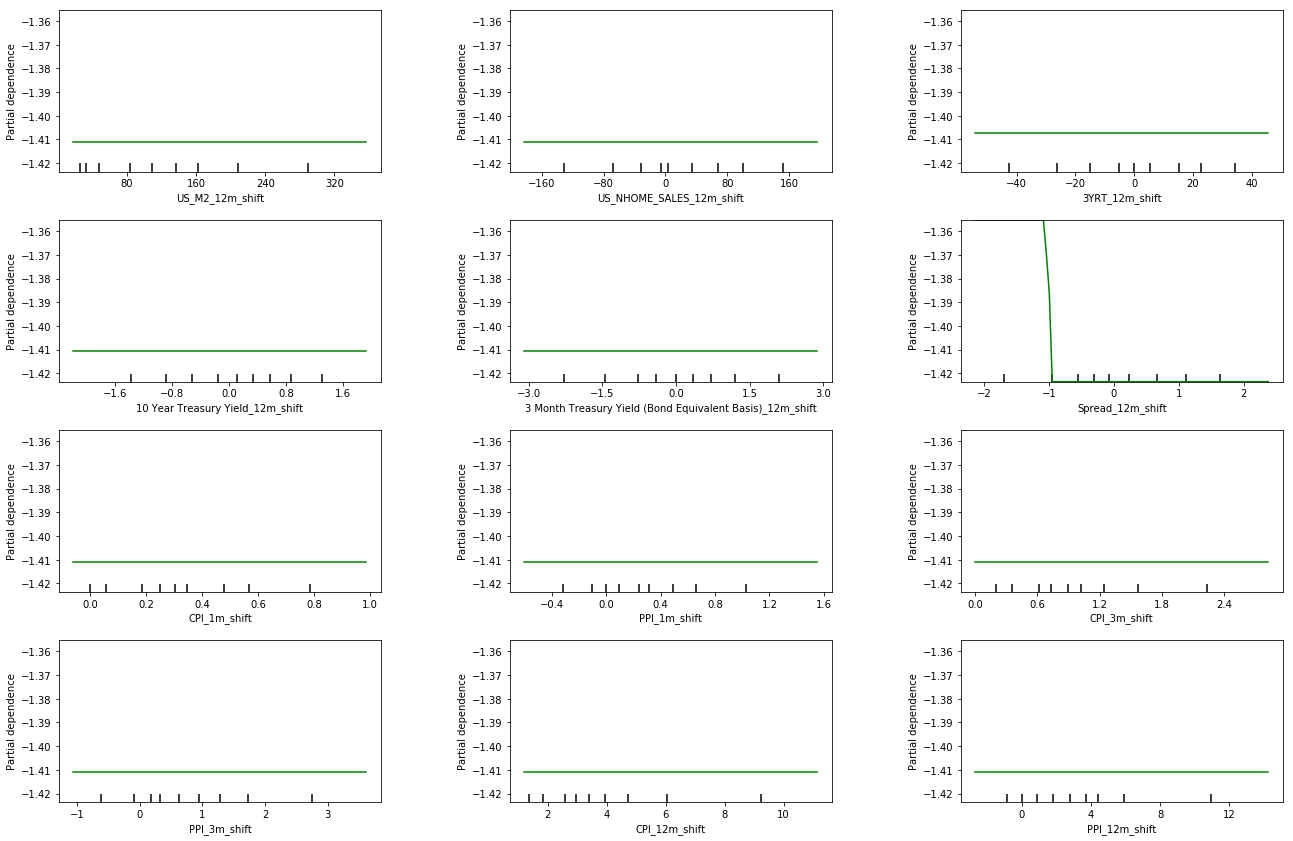

In [170]:
features = range(86,98)
names = list(X_train.columns)

fig, axs = plot_partial_dependence(model, X_train, features,
                                       feature_names=names,
                                       grid_resolution=100,
                                       figsize =(20,20))

plt.savefig('Partial_plots.png')